<a href="https://colab.research.google.com/github/sivanitzhaki/Computer-Vision-Image-classification-assignment/blob/main/Deep_Learning_for_Computer_Vision_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision Image classification project**

I received a dataset comprising images depicting both cats and dogs. My aim is to accurately classify these images.

In [ ]:
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image, display
from PIL import ImageOps

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History as history
from keras.backend import clear_session
from keras.models import Sequential as sequential
from keras.layers import Dense as dense
from keras.layers import Flatten as flatten
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as display_matrix

import warnings
warnings.filterwarnings('ignore')

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#loading the data
x_train = np.load('/content/drive/MyDrive/HW2/X_train.npy')
y_train = np.load('/content/drive/MyDrive/HW2/Y_train.npy')
x_test = np.load('/content/drive/MyDrive/HW2/X_test.npy')
y_test = np.load('/content/drive/MyDrive/HW2/Y_test.npy')

In [ ]:
# set the random seed
np.random.seed(42)
tf.random.set_seed(42)

Exploring the data:

In [ ]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (3200, 180, 180, 3)
Shape of y_train is: (3200,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)


we can see the train data has 3200 samples of images of size 180X180 pixels.

In [ ]:
np.min(x_train), np.max(x_train), x_train.dtype


(0.0, 255.0, dtype('float64'))

Each pixel has integer values ranging from 0 to 255:



In [ ]:
np.min(y_train), np.max(y_train), y_train.dtype


(0.0, 1.0, dtype('float64'))

Our labels are binary, represented by the floats 0.0 and 1.0.

We'll assert the shape of our train set in order to avoid bugs

In [ ]:
assert x_train.shape ==  (3200, 180, 180, 3)

To avoid clipping problems in our network, we'll normalize all the pixels to have values between 0 and 1

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Let's check how the normalization changed the data:

In [ ]:
np.min(x_train), np.max(x_train), x_train.dtype

(0.0, 1.0, dtype('float64'))

In [ ]:
np.min(x_test), np.max(x_test), x_test.dtype

(0.0, 1.0, dtype('float64'))

We would like to see how our data looks

In [ ]:
def plot_random_samples(x, y):
  plt.figure()

  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4})
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')

  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')

  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')

  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')

  plt.show()

<Figure size 432x288 with 0 Axes>

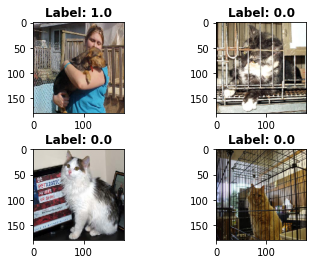

In [ ]:
plot_random_samples(x_train, y_train)

Split the data to train and validation

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=1234)


In [ ]:
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_val is:', x_val.shape)
print('Shape of y_val is:', y_val.shape)
print('Shape of x_test is:', x_val.shape)
print('Shape of y_test is:', y_test.shape)

print(y_train)

Shape of x_train is: (2400, 180, 180, 3)
Shape of y_train is: (2400,)
Shape of x_val is: (800, 180, 180, 3)
Shape of y_val is: (800,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)
[0. 0. 1. ... 0. 1. 0.]


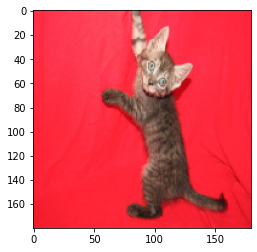

In [ ]:
plt.imshow(x_train[1])


# **Convolutional Nueral Network**

We'll start by building a four-2d convolutional layers followed by two fully connected layer network

In [ ]:
tf.random.set_seed(42)

basic_conv_model = sequential()
basic_conv_model.add(Input(shape=(180, 180, 3)))
basic_conv_model.add(Conv2D(16, kernel_size=(3, 3), activation="relu")) #1st convolution layer with 16 kernels and ReLU activation
basic_conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu")) #2nd convolution layer with 32 kernels and ReLU activation
basic_conv_model.add(MaxPooling2D(pool_size=(2, 2)))  #dimension reduction with maxpooling
basic_conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu")) #3rd convolution layer with 64 kernels and ReLU activation
basic_conv_model.add(MaxPooling2D(pool_size=(2, 2)))  #dimension reduction with maxpooling
basic_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) #4th convolution layer with 128 kernels and ReLU activation
basic_conv_model.add(MaxPooling2D(pool_size=(2, 2))) #dimension reduction with maxpooling
basic_conv_model.add(flatten()) #doing flattening only after we learned the special dependencies between nearby pixels,in order not to lose important information,
basic_conv_model.add(dense(180, activation="relu")) #add a single fully-connected hidden layer
basic_conv_model.add(Dropout(0.5)) #regularization
basic_conv_model.add(dense(1, activation="sigmoid"))

This is our model:

In [ ]:
basic_conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 128)       7

We'll use the binary cross entropy loss because this is a binary classification problem:

In [ ]:
tf.random.set_seed(42)

basic_conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

basic_history = basic_conv_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=12)

Epoch 1/12
75/75 [==============================] - 15s 62ms/step - loss: 0.7021 - accuracy: 0.5042 - val_loss: 0.7055 - val_accuracy: 0.4925
Epoch 2/12
75/75 [==============================] - 4s 56ms/step - loss: 0.6948 - accuracy: 0.5275 - val_loss: 0.6866 - val_accuracy: 0.5450
Epoch 3/12
75/75 [==============================] - 4s 56ms/step - loss: 0.6815 - accuracy: 0.5871 - val_loss: 0.6836 - val_accuracy: 0.5825
Epoch 4/12
75/75 [==============================] - 4s 58ms/step - loss: 0.6718 - accuracy: 0.5992 - val_loss: 0.6784 - val_accuracy: 0.5913
Epoch 5/12
75/75 [==============================] - 4s 57ms/step - loss: 0.6443 - accuracy: 0.6379 - val_loss: 0.6165 - val_accuracy: 0.6662
Epoch 6/12
75/75 [==============================] - 4s 57ms/step - loss: 0.5893 - accuracy: 0.6842 - val_loss: 0.5979 - val_accuracy: 0.6888
Epoch 7/12
75/75 [==============================] - 4s 59ms/step - loss: 0.5329 - accuracy: 0.7358 - val_loss: 0.5656 - val_accuracy: 0.7050
Epoch 8/12
7

Test the model

In [ ]:
basic_train_accuracy = basic_history.history['accuracy'][-1]
basic_train_accuracy

0.9608333110809326

In [ ]:
#run the model on the testing data:
basic_pred = np.round(basic_conv_model.predict(x_test)).flatten()
basic_accuracy = accuracy_score(y_test, basic_pred)
print('Accuracy for our basic CNN model is: ', basic_accuracy)

25/25 [==============================] - 1s 21ms/step
Accuracy for our basic CNN model is:  0.71625


## **Creating our own CNN**

Now we will build a new CNN. We aer basing our network on the basic CNN we presented earlier, and adding defferent regularizations to try and improve it.

In [ ]:
tf.random.set_seed(42)

new_conv_model = sequential()
new_conv_model.add(Input(shape=(180, 180, 3)))

new_conv_model.add(Conv2D(16, kernel_size=(3, 3), activation="relu")) #1st convolution layer with 16 kernels and ReLU activation
new_conv_model.add(MaxPooling2D(pool_size=(2, 2))) #dimension reduction with maxpooling
new_conv_model.add(Dropout(0.1))

new_conv_model.add(Conv2D(32, kernel_size=(3, 3), activation="relu")) #2nd convolution layer with 32 kernels and ReLU activation
new_conv_model.add(MaxPooling2D(pool_size=(2, 2)))  #dimension reduction with maxpooling

new_conv_model.add(Conv2D(64, kernel_size=(3, 3), activation="relu")) #3rd convolution layer with 64 kernels and ReLU activation
new_conv_model.add(MaxPooling2D(pool_size=(2, 2)))  #dimension reduction with maxpooling
new_conv_model.add(Dropout(0.1))

new_conv_model.add(Conv2D(128, kernel_size=(3, 3), activation="relu")) #4th convolution layer with 128 kernels and ReLU activation
new_conv_model.add(MaxPooling2D(pool_size=(2, 2))) #dimension reduction with maxpooling

new_conv_model.add(flatten()) #doing flattening only after we learned the special dependencies between nearby pixels,in order not to lose important information,

new_conv_model.add(dense(180, activation="relu")) #add a single fully-connected hidden layer with ?? 180 neurons? and ReLU activation
new_conv_model.add(Dropout(0.2)) #regularization
new_conv_model.add(dense(1, activation="sigmoid")) #the output layer with sigmoid activation


In [ ]:
new_conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 89, 89, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 64)       

In [ ]:
tf.random.set_seed(42)

new_conv_model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

new_history = new_conv_model.fit(x_train,y_train, epochs=11, validation_data=(x_val, y_val), batch_size=20)

Epoch 1/11
120/120 [==============================] - 4s 22ms/step - loss: 0.7109 - accuracy: 0.5133 - val_loss: 0.6935 - val_accuracy: 0.4913
Epoch 2/11
120/120 [==============================] - 2s 18ms/step - loss: 0.6922 - accuracy: 0.5321 - val_loss: 0.6907 - val_accuracy: 0.5088
Epoch 3/11
120/120 [==============================] - 2s 18ms/step - loss: 0.6773 - accuracy: 0.5883 - val_loss: 0.6581 - val_accuracy: 0.6225
Epoch 4/11
120/120 [==============================] - 2s 19ms/step - loss: 0.6403 - accuracy: 0.6225 - val_loss: 0.6273 - val_accuracy: 0.6225
Epoch 5/11
120/120 [==============================] - 3s 26ms/step - loss: 0.6197 - accuracy: 0.6667 - val_loss: 0.6018 - val_accuracy: 0.6637
Epoch 6/11
120/120 [==============================] - 3s 24ms/step - loss: 0.5817 - accuracy: 0.7025 - val_loss: 0.6315 - val_accuracy: 0.6475
Epoch 7/11
120/120 [==============================] - 2s 18ms/step - loss: 0.5531 - accuracy: 0.7237 - val_loss: 0.6108 - val_accuracy: 0.6662

In [ ]:
new_accuracy = new_history.history['accuracy'][-1]
new_accuracy

0.8583333492279053

In [ ]:
#run the model on the testing data:
new_conv_pred = np.round(new_conv_model.predict(x_test)).flatten()
our_accuracy = accuracy_score(y_test, new_conv_pred)
print('Accuracy for our own CNN model is: ', our_accuracy)

25/25 [==============================] - 0s 11ms/step
Accuracy for our own CNN model is:  0.75625


# **Transfer learning**

We decided to work with ResNet50V2 for this project, because of it's fast training time and it's high accuracy rate.

In [ ]:
#import the ResNet50V2 model to base_model
tf.random.set_seed(42)

input = tf.keras.Input(shape=(180 ,180 ,3))
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=input)
base_model.trainable = False
mid = tf.keras.layers.Flatten()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(mid)

model = tf.keras.Model(base_model.input, output)

94668760/94668760 [==============================] - 2s 0us/step


In [ ]:
#Let's take a look on the imported model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
#compiling the model and running it on our data
tf.random.set_seed(42)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
   tf.keras.callbacks.ModelCheckpoint("imagenet", save_best_only=True)]

transfer_history = model.fit(x_train,y_train, epochs=10, validation_data=(x_val, y_val), callbacks=callbacks, batch_size=32)

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.4473 - accuracy: 0.9500

75/75 [==============================] - 27s 317ms/step - loss: 0.4473 - accuracy: 0.9500 - val_loss: 0.5045 - val_accuracy: 0.9600
Epoch 2/10
75/75 [==============================] - 7s 90ms/step - loss: 0.1363 - accuracy: 0.9867 - val_loss: 0.7883 - val_accuracy: 0.9563
Epoch 3/10
75/75 [==============================] - 7s 90ms/step - loss: 0.0790 - accuracy: 0.9896 - val_loss: 0.8767 - val_accuracy: 0.9500
Epoch 4/10
75/75 [==============================] - 8s 103ms/step - loss: 0.0165 - accuracy: 0.9975 - val_loss: 0.6897 - val_accuracy: 0.9600
Epoch 5/10
75/75 [==============================] - 8s 104ms/step - loss: 0.0144 - accuracy: 0.9979 - val_loss: 0.5320 - val_accuracy: 0.9712
Epoch 6/10
75/75 [==============================] - 8s 103ms/step - loss: 7.9225e-05 - accuracy: 1.0000 - val_loss: 0.5253 - val_accuracy: 0.9737
Epoch 7/10
75/75 [==============================] - 7s 90ms/step - loss: 4.2731e-06 - accuracy: 1.0000 - val_loss: 0.5255 - val_accuracy: 0.9737
Epoch 8/10


In [ ]:
transfer_train_accuracy = transfer_history.history['accuracy'][-1]
transfer_train_accuracy

1.0

In [ ]:
test_pred = np.round(model.predict(x_test)).flatten()
transfer_accuracy = accuracy_score(y_test, test_pred)
print('Accuracy for the transfer CNN model is: ', transfer_accuracy)

25/25 [==============================] - 2s 65ms/step
Accuracy for the transfer CNN model is:  0.97


# **Visualization and Evaluation**

In [ ]:
#plotting pictures with the wrong prediction
def plot_random_wrong(pred, model_name):

  wrong_pred = np.array(np.where(y_test != pred)).flatten()
  random_idx = np.random.choice(wrong_pred, 4)

  plt.figure()
  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4})

  axarr[0, 0].imshow(x_test[random_idx[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(pred[random_idx[0]]), fontweight='bold')

  axarr[1, 0].imshow(x_test[random_idx[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(pred[random_idx[1]]), fontweight='bold')

  axarr[0, 1].imshow(x_test[random_idx[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(pred[random_idx[2]]), fontweight='bold')

  axarr[1, 1].imshow(x_test[random_idx[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(pred[random_idx[3]]), fontweight='bold')

  plt.suptitle("Wrong Perdicteions of " + model_name + " Model\n", fontweight='bold')
  plt.show()

<Figure size 432x288 with 0 Axes>

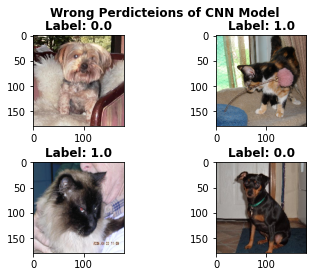

<Figure size 432x288 with 0 Axes>

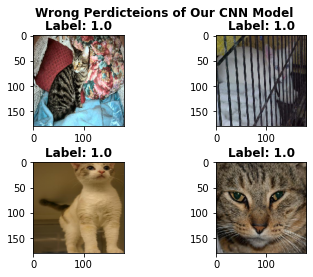

<Figure size 432x288 with 0 Axes>

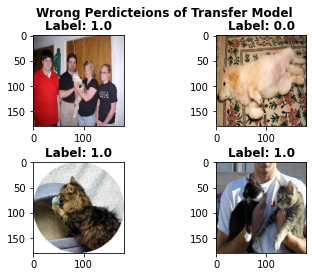

In [ ]:
plot_random_wrong(basic_pred, "CNN")
plot_random_wrong(new_conv_pred, "Our CNN")
plot_random_wrong(test_pred, "Transfer")

Plotting confusion matrix

In [ ]:
def plot_conf_matrix(prediction, model_name):
  matrix = confusion_matrix(y_test, prediction)
  im = display_matrix(matrix)
  im.plot()
  plt.title("Confusion Matrix for " + model_name + " Model")
  plt.show()

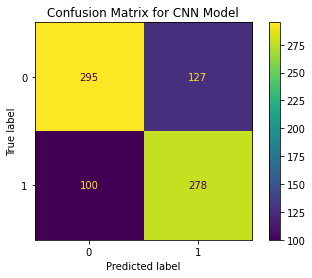

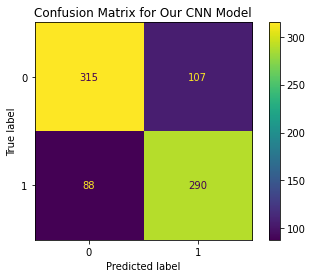

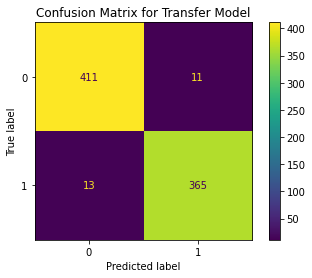

In [ ]:
plot_conf_matrix(basic_pred, "CNN")
plot_conf_matrix(new_conv_pred, "Our CNN")
plot_conf_matrix(test_pred, "Transfer")

# Summary

In [ ]:
# generate the CSV file

results = {'model': ['Basic CNN', 'Our CNN Model', 'ResNet50V2 Transfer Learning'],
           'Test score (Accuracy)': [str(basic_accuracy), str(our_accuracy), str(transfer_accuracy)],
           'Train score (Accuracy)': [str(basic_train_accuracy), str(new_accuracy), str(transfer_train_accuracy)],
           'Number of trainable parameters': [9313801 , 1964041, 73729],
           'Number of layers': [len(basic_conv_model.layers), len(new_conv_model.layers), len(model.layers)],
           'Regularization methods': ['None', 'Dropout', 'None (other than the ones implemented in the transfered model)'],
           'Number of epochs': [12 , 11 , 10],
           'Loss function': ['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'],
           'Optimizer': ['adam', 'adam', 'adam']
           }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,Basic CNN,0.71625,0.9608333110809326,9313801,11,None,12,binary_crossentropy,adam
1,Our CNN Model,0.75625,0.8583333492279053,1964041,14,Dropout,11,binary_crossentropy,adam
2,ResNet50V2 Transfer Learning,0.97,1.0,73729,192,None (other than the ones implemented in the t...,10,binary_crossentropy,adam


In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise2.csv'))